<a href="https://colab.research.google.com/github/dadabeckmann/Masterarbeit_Code/blob/main/GEE_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Räumliche Statistiken

In [9]:
import ee
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-dbeckmann')

## Import Packages


In [ ]:
# Packages
import ee
import matplotlib.pyplot as plt # for plots
import branca.colormap as cm # for colormaps
import folium
import geemap
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime


## Wolken Filter und Beobachtungsdauer

In [8]:
# Load in Shapefile
regionInt = ee.FeatureCollection('users/dbeckmann/Tuebingen_Shape')

# Define constants
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
MAX_CLOUD_COVER = 50

# Function to filter out cloudy pixels
def cloud_mask(img):
    cloud_shadow_bit_mask = (1 << 3)  # Bits 3 and 5 are cloud shadow and cloud, respectively.
    clouds_bit_mask = (1 << 5)
    qa = img.select('QA_PIXEL')  # Get the pixel QA band.
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0) \
                 .And(qa.bitwiseAnd(clouds_bit_mask).eq(0))  # Both flags should be set to zero, indicating clear conditions.
    return img.updateMask(mask)

# Load the collection, apply cloud mask, and filter to date and region of interest.
col_before = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
    .filterDate(START_DATE, END_DATE)

col_count_before = col_before.size().getInfo()
print('Col before Cloud Filter:', col_count_before)

col_after = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
    .filterBounds(regionInt) \
    .filterDate(START_DATE, END_DATE) \
    .map(cloud_mask) \
    .filter(ee.Filter.lt('CLOUD_COVER', MAX_CLOUD_COVER))




Col before Cloud Filter: 164698


## Anzahl an genutzen Bildern

In [ ]:
# Count used images
image_count = col_after.size().getInfo()
print('Number of images in Sentinel-2 collection:', image_count)

# Show dates of used images
dates = col_after.aggregate_array('system:time_start')
formatted_dates = ee.List(dates).map(lambda date: ee.Date(date).format('YYYY-MM-dd')).sort().getInfo()

# Print the sorted dates
print('Used Dates:', formatted_dates)


Number of images in Sentinel-2 collection: 11
Used Dates: ['2018-03-08', '2018-03-24', '2018-04-25', '2018-05-18', '2018-06-03', '2018-07-14', '2018-07-30', '2018-08-06', '2018-08-22', '2018-09-16', '2018-10-18']


## Median LST von Untersuchungsgebiet

In [10]:
# Generate median composite
image = col_after.median()

# Select thermal band 10 (with brightness temperature)
thermal = image.select('B10') \
    .clip(regionInt) \

# Calculate Normalized Difference Vegetation Index (NDVI) from Landsat surface reflectance
ndvi = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(regionInt) \
    .filterDate('2018-01-01', '2018-12-31') \
    .median() \
    .normalizedDifference(['SR_B5', 'SR_B4']) \
    .rename('NDVI') \
    .clip(regionInt) \

# Find the minimum and maximum of NDVI
min_max = ndvi.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=regionInt,
    scale=30,
    maxPixels=1e9
)

# Calculate fractional vegetation
min_val = ee.Number(min_max.get('NDVI_min'))
max_val = ee.Number(min_max.get('NDVI_max'))
fv = ndvi.subtract(min_val).divide(max_val.subtract(min_val)).rename('FV')

# Emissivity calculations
a = ee.Number(0.004)
b = ee.Number(0.986)
em = fv.multiply(a).add(b).rename('EMM')

# Calculate LST from emissivity and brightness temperature
lst_landsat_median = thermal.expression(
    '(Tb / (1 + (0.001145 * (Tb / 1.438)) * log(Ep))) - 273.15',
    {
        'Tb': thermal.select('B10'),
        'Ep': em.select('EMM')
    })

# Function to load in the vizparams

def add_ee_layer(map, ee_image, vis_params, region, name):
    """Add Earth Engine tile layer to Folium map."""
    # Get the URL of the Earth Engine TileLayer with a specified region and visualization parameters
    tile_url = ee_image.getMapId(vis_params)['tile_fetcher'].url_format

    # Add Earth Engine tile layer to Folium map
    folium.TileLayer(
        tiles=tile_url,
        attr=name,
        name=name,
        overlay=True,
    ).add_to(map)

    return map

# Create a map centered around the region of interest
map = folium.Map(location=[48.521637, 9.057645], zoom_start=10)

# Define visualization parameters
thermal_vis = {'min': 295, 'max': 310, 'palette': ['#2b83ba', '#abdda4', '#ffffbf', '#fdae61', '#d7191c', '#abdda4']}
ndvi_vis = {'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}
fv_vis = {'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}
em_vis = {'min': 0, 'max': 0.99, 'palette': ['blue', 'white', 'green']}
lst_vis = {'min': 15, 'max': 35, 'palette': ['#2b83ba', '#abdda4', '#ffffbf', '#fdae61', '#d7191c', '#abdda4']}

# Add layers to the map using the function
map = add_ee_layer(map, thermal, thermal_vis, regionInt, 'Landsat_BT')
map = add_ee_layer(map, ndvi, ndvi_vis, regionInt, 'NDVI')
map = add_ee_layer(map, ndvi, fv_vis, regionInt, 'Fractional Vegetation')
map = add_ee_layer(map, ndvi, em_vis, regionInt, 'Emissivity')
map = add_ee_layer(map, lst_landsat_median, lst_vis, regionInt, 'LST_Landsat_Median')

# Add layer control to toggle different layers
folium.LayerControl().add_to(map)

# Create a color map for the temperature range
temperature_colormap = cm.LinearColormap(lst_vis['palette'],
                                         vmin=lst_vis['min'],
                                         vmax=lst_vis['max'])
legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; z-index:1000; background-color: white; border: 2px solid grey; padding: 10px;">
        <p><strong>Legend:</strong></p>
        <p><span style="background-color: #2b83ba; padding: 2px 5px;"></span> 15°C - 20°C</p>
        <p><span style="background-color: #abdda4; padding: 2px 5px;"></span> 20°C - 25°C</p>
        <p><span style="background-color: #ffffbf; padding: 2px 5px;"></span> 25°C - 30°C</p>
        <p><span style="background-color: #fdae61; padding: 2px 5px;"></span> 30°C - 35°C</p>
        <p><span style="background-color: #d7191c; padding: 2px 5px;"></span> > 35°C</p>
    </div>
'''

# Add the color map to the map legend
temperature_colormap.caption = 'Temperature (°C)'
map.add_child(temperature_colormap)

# map.get_root().html.add_child(folium.Element(legend_html))

# Display the map
map

## Erstellung der verschiedenen Strukturtypen

In [71]:
# Load the FeatureCollection representing Tuebingen's shape
regionInt = ee.FeatureCollection('users/dbeckmann/Tuebingen_Shape')

# Define a function to add an Earth Engine layer to a folium map
def add_ee_layer(map, ee_image_object, vis_params, region, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(map)

    # Add the region of interest as another layer
    folium.GeoJson(
        data=region.getInfo(),
        name='Region of Interest',
        overlay=True,
        style_function=lambda x: {'fillColor': 'none', 'color': 'black', 'weight': 2, 'opacity': 0.7},
    ).add_to(map)
    return map

# Structure Type LST Maps
image = ee.Image("JRC/GHSL/P2023A/GHS_BUILT_C/2018")
GHSL = image.select('built_characteristics')

# Mask for areas that are not urban or open space
maskNotUrbanOrOpenSpace = maskUrban.Not().And(maskOpenSpace.Not())

# Define masks for different structure types
maskOpenSpace = GHSL.eq(1).Or(GHSL.eq(2)).Or(GHSL.eq(3)).Or(GHSL.eq(4))
maskBuiltSpacesRes = GHSL.eq(11).Or(GHSL.eq(12)).Or(GHSL.eq(13)).Or(GHSL.eq(14)).Or(GHSL.eq(15))
maskBuiltSpacesNonRes = GHSL.eq(5).Or(GHSL.eq(21)).Or(GHSL.eq(22)).Or(GHSL.eq(23)).Or(GHSL.eq(24)).Or(GHSL.eq(25))
maskUrban = maskBuiltSpacesRes.Or(maskBuiltSpacesNonRes)
maskOpenSpaceOuterCity = (maskUrban.Not())
maskAll = (regionInt)

# Convert the region of interest FeatureCollection to an image mask
mask_image = ee.Image.constant(1).clipToCollection(regionInt)

# Apply masks to NDVI, emissivity, and LST calculations using the mask image
ndvi_all = ndvi.updateMask(mask_image)
em_all = em.updateMask(mask_image)
lst_all = lst_landsat_median.updateMask(mask_image)

ndvi_open_space_outer_city = ndvi.updateMask(maskOpenSpaceOuterCity)
em_open_space_outer_city = em.updateMask(maskOpenSpaceOuterCity)
lst_open_space_outer_city = lst_landsat_median.updateMask(maskOpenSpaceOuterCity)

ndvi_open_space = ndvi.updateMask(maskOpenSpace)
em_open_space = em.updateMask(maskOpenSpace)
lst_open_space = lst_landsat_median.updateMask(maskOpenSpace)

ndvi_built_res = ndvi.updateMask(maskBuiltSpacesRes)
em_built_res = em.updateMask(maskBuiltSpacesRes)
lst_built_res = lst_landsat_median.updateMask(maskBuiltSpacesRes)

ndvi_built_non_res = ndvi.updateMask(maskBuiltSpacesNonRes)
em_built_non_res = em.updateMask(maskBuiltSpacesNonRes)
lst_built_non_res = lst_landsat_median.updateMask(maskBuiltSpacesNonRes)

ndvi_urban = ndvi.updateMask(maskUrban)
em_urban = em.updateMask(maskUrban)
lst_urban = lst_landsat_median.updateMask(maskUrban)

# Visualize the results
map = folium.Map(location=[48.521637, 9.057645], zoom_start=12)
map = add_ee_layer(map, lst_open_space, lst_vis, regionInt, 'LST_Open_Space')
map = add_ee_layer(map, lst_built_res, lst_vis, regionInt, 'LST_Built_Res')
map = add_ee_layer(map, lst_built_non_res, lst_vis, regionInt, 'LST_Built_Non_Res')
map = add_ee_layer(map, lst_urban, lst_vis, regionInt, 'LST_Urban')
map = add_ee_layer(map, lst_open_space_outer_city, lst_vis, regionInt, 'LST Open Space Outer City')
map = add_ee_layer(map, lst_all, lst_vis, regionInt, 'Region of Interest Mask')  # Corrected here

# Add layer control
folium.LayerControl().add_to(map)

# Display the map
map


## Median LST der Strukturtypen



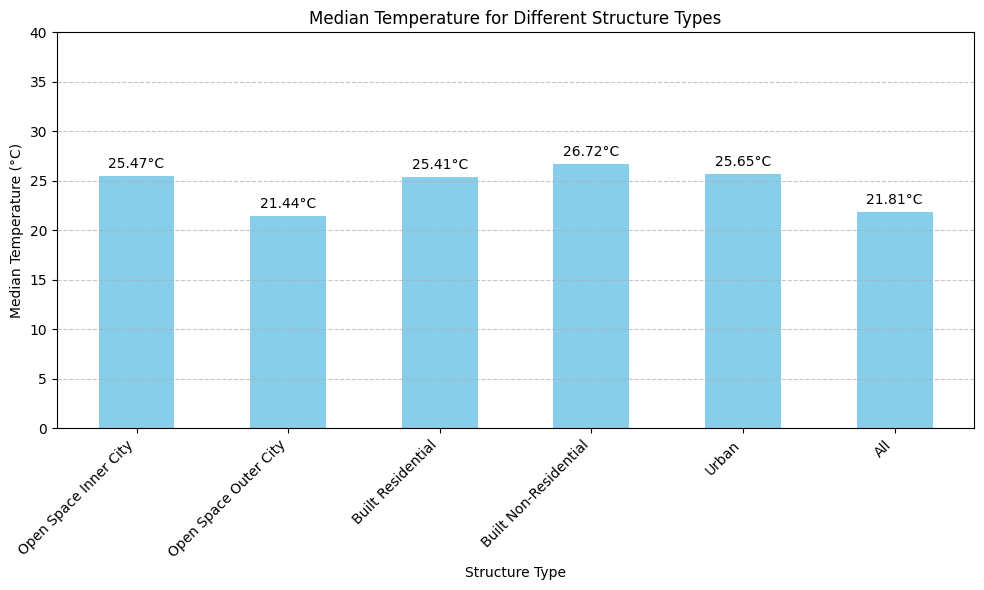

In [72]:
# Calculate median temperature for each structure type
median_lst_open_space_inner_city = lst_open_space.reduceRegion(reducer=ee.Reducer.median(), geometry=regionInt, scale=30, maxPixels=1e9).get('B10')
median_lst_built_res = lst_built_res.reduceRegion(reducer=ee.Reducer.median(), geometry=regionInt, scale=30, maxPixels=1e9).get('B10')
median_lst_built_non_res = lst_built_non_res.reduceRegion(reducer=ee.Reducer.median(), geometry=regionInt, scale=30, maxPixels=1e9).get('B10')
median_lst_urban = lst_urban.reduceRegion(reducer=ee.Reducer.median(), geometry=regionInt, scale=30, maxPixels=1e9).get('B10')
median_lst_open_space_outer_city = lst_open_space_outer_city.reduceRegion(reducer=ee.Reducer.median(), geometry=regionInt, scale=30, maxPixels=1e9).get('B10')
median_lst = lst_all.reduceRegion(reducer=ee.Reducer.median(), geometry=regionInt, scale=30, maxPixels=1e9).get('B10')

# Convert median temperatures from Earth Engine objects to Python variables
median_lst_open_space_inner_city = median_lst_open_space_inner_city.getInfo()
median_lst_built_res = median_lst_built_res.getInfo()
median_lst_built_non_res = median_lst_built_non_res.getInfo()
median_lst_urban = median_lst_urban.getInfo()
median_lst_open_space_outer_city = median_lst_open_space_outer_city.getInfo()
median_lst_all = median_lst.getInfo()
# Define structure types and their median temperatures
structure_types = ['Open Space Inner City', 'Open Space Outer City', 'Built Residential', 'Built Non-Residential', 'Urban', 'All']
median_temperatures = [median_lst_open_space_inner_city, median_lst_open_space_outer_city, median_lst_built_res, median_lst_built_non_res, median_lst_urban, median_lst_all]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(structure_types, median_temperatures, color='skyblue', width=0.5)

# Add data labels to the bars
for bar, temp in zip(bars, median_temperatures):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{temp:.2f}°C', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Structure Type')
plt.ylabel('Median Temperature (°C)')
plt.title('Median Temperature for Different Structure Types')

# Customize the plot
plt.ylim(0, 40)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show plot
plt.show()


## Fläche der einzelnen Strukturtypen

Urban Structures (km²): 8.620380186558803
Open Spaces Inner City (km²): 8.910002205887947
Open Spaces Outer City (km²): 99.30008759202772
Built Spaces Residential (km²): 6.7967076006404525
Built Spaces Non-Residential (km²): 1.8236725859183516
All (km²): 107.92


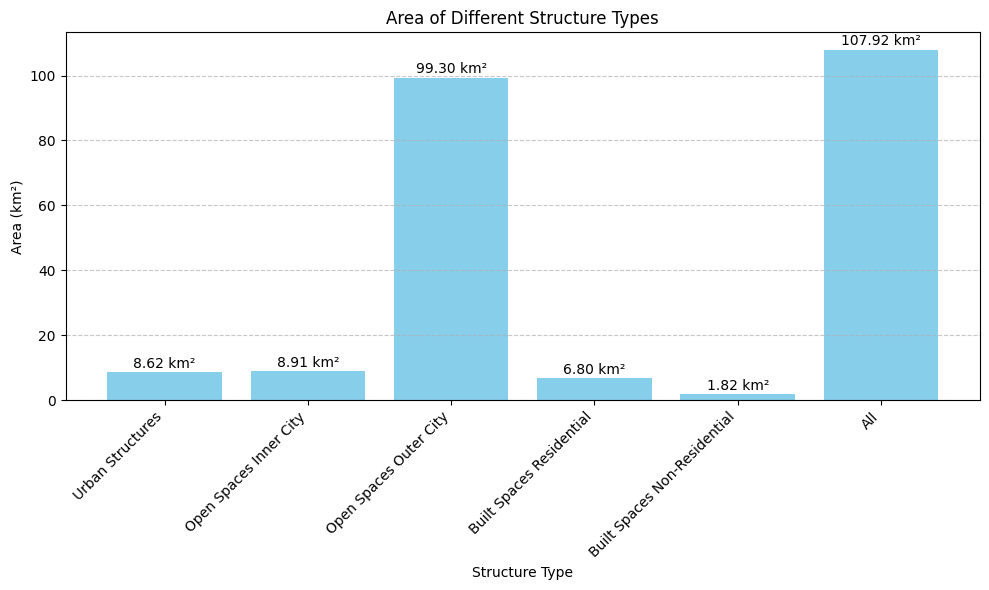

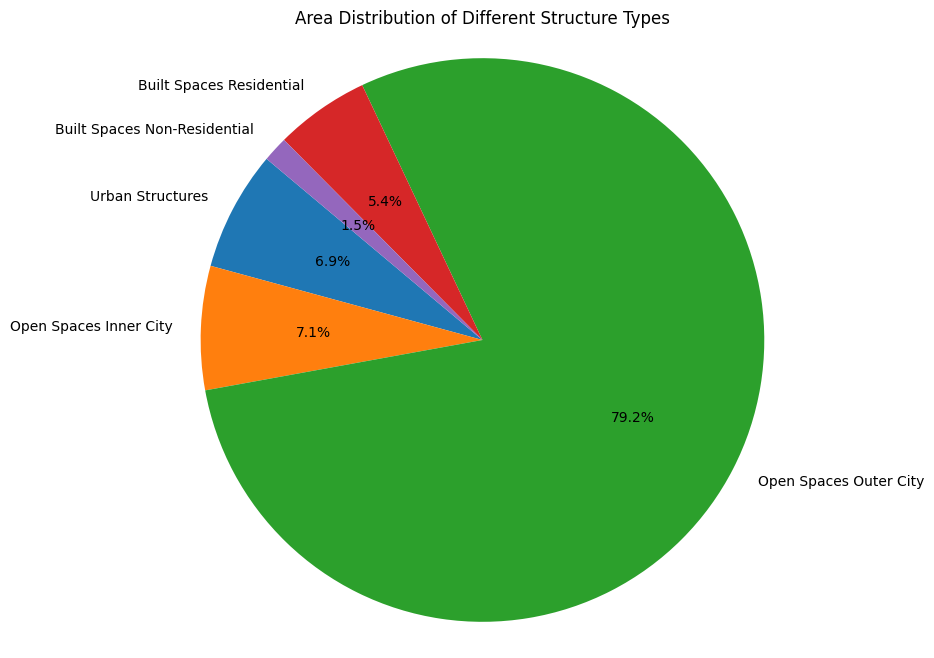

In [84]:
# Define a function to calculate the area of a given structure type
def calculate_area(image):
    # Multiply the image by pixel area to get the area in square meters
    area_image = image.multiply(ee.Image.pixelArea())

    # Reduce the area image within the specified region
    area_stats = area_image.reduceRegion(reducer=ee.Reducer.sum(), geometry=regionInt.geometry(), scale=10)

    # Get the sum of the area
    area_sqm = area_stats.get('built_characteristics')  # Correct the property name if needed

    # Convert to square kilometers
    area_sqkm = ee.Number(area_sqm).divide(1e6)

    return area_sqkm

# Calculate areas for each structure type
urban_area_sqkm = calculate_area(maskUrban)
openSpacesInner_area_sqkm = calculate_area(maskOpenSpaceInnerCity)
openSpacesOuter_area_sqkm = calculate_area(maskOpenSpaceOuterCity)
builtSpacesRes_area_sqkm = calculate_area(maskBuiltSpacesRes)
builtSpacesNonRes_area_sqkm = calculate_area(maskBuiltSpacesNonRes)

# Define a function to calculate the area of a given region
def calculate_region_area(region):
    # Create an image representing the region
    region_image = ee.Image.constant(1).clipToCollection(region)

    # Multiply the region image by pixel area to get the area in square meters
    area_image = region_image.multiply(ee.Image.pixelArea())

    # Reduce the area image to get the sum of pixel values, representing the total area
    area_stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region.geometry(),
        scale=10
    )

    # Get the sum of the area in square meters
    area_sqm = area_stats.get('constant')

    # Convert the area from square meters to square kilometers
    area_sqkm = ee.Number(area_sqm).divide(1e6)

    return area_sqkm.getInfo()  # Return the area in square kilometers

# Calculate the area of the region of interest
region_area_sqkm = calculate_region_area(regionInt)

# Print the results
print('Urban Structures (km²):', urban_area_sqkm.getInfo())
print('Open Spaces Inner City (km²):', openSpacesInner_area_sqkm.getInfo())
print('Open Spaces Outer City (km²):', openSpacesOuter_area_sqkm.getInfo())
print('Built Spaces Residential (km²):', builtSpacesRes_area_sqkm.getInfo())
print('Built Spaces Non-Residential (km²):', builtSpacesNonRes_area_sqkm.getInfo())
print('All (km²):', round(region_area_sqkm, 2))

# Define structure types and their areas
structure_types = ['Urban Structures', 'Open Spaces Inner City', 'Open Spaces Outer City', 'Built Spaces Residential', 'Built Spaces Non-Residential', 'All']
areas_sqkm = [urban_area_sqkm.getInfo(), openSpacesInner_area_sqkm.getInfo(), openSpacesOuter_area_sqkm.getInfo(), builtSpacesRes_area_sqkm.getInfo(), builtSpacesNonRes_area_sqkm.getInfo(), region_area_sqkm]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(structure_types, areas_sqkm, color='skyblue')

# Add data labels to the bars
for bar, area in zip(bars, areas_sqkm):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{area:.2f} km²', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Structure Type')
plt.ylabel('Area (km²)')
plt.title('Area of Different Structure Types')

# Customize the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show plot
plt.show()


# Define structure types and their areas
structure_types = ['Urban Structures', 'Open Spaces Inner City', 'Open Spaces Outer City', 'Built Spaces Residential', 'Built Spaces Non-Residential']
areas_sqkm = [urban_area_sqkm.getInfo(), openSpacesInner_area_sqkm.getInfo(), openSpacesOuter_area_sqkm.getInfo(), builtSpacesRes_area_sqkm.getInfo(), builtSpacesNonRes_area_sqkm.getInfo()]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(areas_sqkm, labels=structure_types, autopct='%1.1f%%', startangle=140)
plt.title('Area Distribution of Different Structure Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show plot
plt.show()




In [75]:
import ee

# Initialize Earth Engine
ee.Initialize()

def calculate_region_area(region):
    # Create an image representing the region
    region_image = ee.Image.constant(1).clipToCollection(region)

    # Multiply the region image by pixel area to get the area in square meters
    area_image = region_image.multiply(ee.Image.pixelArea())

    # Reduce the area image to get the sum of pixel values, representing the total area
    area_stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region.geometry(),  # Add the geometry parameter here
        scale=10
    )

    # Get the sum of the area in square meters
    area_sqm = area_stats.get('constant')

    # Convert the area from square meters to square kilometers
    area_sqkm = ee.Number(area_sqm).divide(1e6)

    return area_sqkm.getInfo()  # Return the area in square kilometers

# Example usage:
# Assuming 'regionInt' is the region of interest defined as a FeatureCollection in Earth Engine
region_area_sqkm = calculate_region_area(regionInt)
print('Area of the region of interest:', round(region_area_sqkm, 2), 'square kilometers')


Area of the region of interest: 107.92 square kilometers


## Erstellen eine Datenrahmes mit LST Wert und Datum von den Bildern im Zeitraum

In [ ]:
# Function to calculate LST from NDVI, emissivity, and brightness temperature
def calculate_lst(img):
    # Calculate NDVI
    ndvi = img.normalizedDifference(['B5', 'B4']).rename('NDVI')

    # Find the minimum and maximum of NDVI
    min_max = ndvi.reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=regionInt,
        scale=30,
        maxPixels=1e9
    )

    # Calculate fractional vegetation
    min_val = ee.Number(min_max.get('NDVI_min'))
    max_val = ee.Number(min_max.get('NDVI_max'))
    fv = ndvi.subtract(min_val).divide(max_val.subtract(min_val)).rename('FV')

    # Emissivity calculations
    a = ee.Number(0.004)
    b = ee.Number(0.986)
    em = fv.multiply(a).add(b).rename('EMM')

    # Calculate LST using emissivity and brightness temperature
    tb = img.select('B10')
    lst = tb.expression(
        '(Tb / (1 + (0.001145 * (Tb / 1.438)) * log(Em))) - 273.15',
        {
            'Tb': tb,
            'Em': em
        }
    ).rename('LST')

    return lst

# Iterate over the used dates
for date in formatted_dates:
    # Filter the collection for the current date
    col_filtered = col_after.filterDate(date)

    # Apply the function to calculate LST for each image in the filtered collection
    col_lst_filtered = col_filtered.map(calculate_lst)

    # Generate a median composite of the LST images from the filtered collection
    median_lst_filtered = col_lst_filtered.median()

    # Add the median LST composite to the map with a name indicating the date
    map.add_ee_layer(median_lst_filtered, lst_vis, regionInt, f'Median LST ({date})')

# Display the map
display(map)

NameError: name 'formatted_dates' is not defined

# Temporale Statistiken

## Import Packages

In [ ]:
# Import packages
import pandas as pd
import os
import numpy as np
import plotly.graph_objects as go
from scipy.stats import linregress
from matplotlib.dates import YearLocator


## Pandas Zeitreihe

### Einzelne Zeitreihenanalyse

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory where the CSV files are located
directory = "/content/drive/MyDrive/Data/LST"

# Iterate over each file in the directory
for file_name in os.listdir(directory):
    if file_name.endswith(".csv"):  # Check if the file is a CSV file
        # Read the CSV file
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path)

        # Change column header
        df = df.rename(columns={'system:time_start': 'Date'})

        # Filter out rows with negative values in the 'LST' column
        df = df[df['LST'] >= 0]

        # Set 'Date' column as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Split filename by underscores and take the last part
        file_name_parts = file_name.split('_')
        last_part = file_name_parts[-1].replace('.csv', '')

        # Plot the time series with trendline
        plt.figure(figsize=(12, 8))
        plt.plot(df.index, df['LST'], color='skyblue', linestyle='-', linewidth=2, label='LST Data')
        plt.title(f'Zeitreihe der Oberflächentemperatur in {last_part}', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Temperature (°C)', fontsize=14)
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        plt.grid(True, alpha=0.3)

        # Perform linear regression
        x = np.arange(len(df))
        slope, intercept, _, _, _ = linregress(x, df['LST'])

        # Plot the trendline
        plt.plot(df.index, slope*x + intercept, color='red', linestyle='--', linewidth=2, label='Trendline')

        plt.legend(fontsize=12)

        # Add year locator to x-axis
        plt.gca().xaxis.set_major_locator(YearLocator())
        plt.tight_layout()
        plt.show()


In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
from matplotlib.dates import YearLocator

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory where the CSV files are located
directory = "/content/drive/MyDrive/Data"

# Iterate over each file in the directory
for file_name in os.listdir(directory):
    if file_name.endswith(".csv"):  # Check if the file is a CSV file
        # Read the CSV file
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path)

        # Change column header
        df = df.rename(columns={'system:time_start': 'Date'})

        # Filter out rows with negative values in the 'LST' column
        df = df[df['LST'] >= 0]

        # Set 'Date' column as index
        df['Date'] = pd.to_datetime(df['Date'])

        # Calculate the mean temperature for each year
        df['Year'] = df['Date'].dt.year
        mean_temperature_by_year = df.groupby('Year')['LST'].mean()

        # Split filename by underscores and take the last part
        file_name_parts = file_name.split('_')
        last_part = file_name_parts[-1].replace('.csv', '')

        # Calculate linear regression
        slope, intercept, _, _, _ = linregress(mean_temperature_by_year.index, mean_temperature_by_year.values)

        # Plot the mean temperature for every year with a trendline
        plt.figure(figsize=(12, 6))
        plt.plot(mean_temperature_by_year.index, mean_temperature_by_year.values, linestyle='-', color='skyblue', label='Mean Temperature')
        plt.plot(mean_temperature_by_year.index, slope * mean_temperature_by_year.index + intercept, linestyle='--', color='red', label='Trendline')
        plt.title(f'Mean Temperature per Year with Trendline - {last_part}', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Mean Temperature', fontsize=14)
        plt.xticks(mean_temperature_by_year.index, fontsize=12, rotation=45)  #
        plt.yticks(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)

        plt.tight_layout()
        plt.show()


### Vergleichende Zeitreihenanalyse

In [ ]:
from matplotlib.dates import YearLocator

def process_and_plot_dataframes(file_paths):
    """
    Read in CSV files, rename a column, set index,
    and drop rows with negative values in a specific column for each DataFrame.
    Align the DataFrames based on the date index.
    Plot multiple time series in one plot with trendlines.

    Args:
    - file_paths (list of str): List of file paths to the CSV files
    """
    plt.figure(figsize=(12, 8))

    # Dictionary to store processed DataFrames
    processed_dfs = {}

    for file_path in file_paths:
        # Extract filename without directory path and extension
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        last_part = file_name.split('_')[-1]

        if last_part not in processed_dfs:  # Check if filename already exists in dictionary
            # Read the CSV file
            df = pd.read_csv(file_path)

            # Change column header
            df = df.rename(columns={'system:time_start': 'Date'})

            # Set 'Date' column as index
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)

            # Drop rows containing negative values in the 'LST' column
            df = df[df['LST'] >= 0]

            # Remove duplicate rows
            df = df[~df.index.duplicated()]

            # Store processed DataFrame in the dictionary
            processed_dfs[last_part] = df

    # Perform outer join on date index to align DataFrames
    aligned_df = pd.concat(processed_dfs.values(), axis=1, join='outer')

    # Drop rows containing NaN values after aligning
    aligned_df.dropna(inplace=True)

    # Plot time series
    for filename, df in processed_dfs.items():
        plt.plot(df.index, df['LST'], label=filename)

    # Add plot labels and legend
    plt.title('Time Series of LST (Land Surface Temperature)', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('LST', fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.gca().xaxis.set_major_locator(YearLocator())  # Show only the years on the x-axis
    plt.tight_layout()
    plt.show()

# Example usage:
file_paths = ["LST_Time_Series_Esslingen.csv", "LST_Time_Series_Stuttgart.csv"]
process_and_plot_dataframes(file_paths)


## Plotly Zeitreihe

In [ ]:
# Change directory to where your CSV file is located
os.chdir("/content/drive/MyDrive/Data/LST")

# First DF
file_path = "LST_Time_Series_Esslingen.csv"
df = pd.read_csv(file_path)

# Change column header
df = df.rename(columns={'system:time_start': 'Date'})
df_drop = df.dropna()

# Set 'Date' column as index for df_drop
df_drop.set_index('Date', inplace=True)

# Drop rows containing negative values in the 'LST' column
df_new = df_drop[df_drop['LST'] >= 0]

# Extract filename without directory path and extension
file_name = os.path.splitext(os.path.basename(file_path))[0]

# Split filename by underscores and take the last part
file_name_parts = file_name.split('_')
last_part = file_name_parts[-1]

# Create trace for LST data
trace_lst = go.Scatter(x=df_new.index, y=df_new['LST'], mode='lines', name='LST Data', line=dict(color='skyblue'))

# Perform linear regression
x = np.arange(len(df_new))
m, b = np.polyfit(x, df_new['LST'], 1)

# Calculate trendline
trendline = m * x + b

# Create trace for trendline
trace_trendline = go.Scatter(x=df_new.index, y=trendline, mode='lines', name='Trendline', line=dict(color='red', dash='dash'))

# Create layout
layout = go.Layout(title=f'Zeitreihe der Oberflächentemperatur von 2000-2023 in {last_part}',
                   xaxis=dict(title='Datum'),
                   yaxis=dict(title='Temperatur in °C'),
                   legend=dict(font=dict(size=12)))

# Create figure
fig = go.Figure(data=[trace_lst, trace_trendline], layout=layout)

# Show plot
fig.show()


### Einzelne Zeitreihenanalyse

In [ ]:
import pandas as pd
import os
import numpy as np
import plotly.graph_objs as go
from scipy.stats import linregress

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory where the CSV files are located
directory = "/content/drive/MyDrive/Data/LST"

# Iterate over each file in the directory
for file_name in os.listdir(directory):
    if file_name.endswith(".csv"):  # Check if the file is a CSV file
        # Read the CSV file
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path)

        # Change column header
        df = df.rename(columns={'system:time_start': 'Date'})

        # Drop rows containing negative values in the 'LST' column
        df = df[df['LST'] >= 0]

        # Set 'Date' column as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Extract filename without directory path and extension
        file_name = os.path.splitext(os.path.basename(file_path))[0]

        # Split filename by underscores and take the last part
        file_name_parts = file_name.split('_')
        last_part = file_name_parts[-1].replace('.csv', '')

        # Perform linear regression
        x = np.arange(len(df))
        m, b = np.polyfit(x, df['LST'], 1)

        # Calculate trendline
        trendline = m * x + b

        # Create trace for LST data
        trace_lst = go.Scatter(x=df.index, y=df['LST'], mode='lines', name='LST Data', line=dict(color='skyblue'))

        # Create trace for trendline
        trace_trendline = go.Scatter(x=df.index, y=trendline, mode='lines', name='Trendline', line=dict(color='red', dash='dash'))

        # Create layout
        layout = go.Layout(title=f'Zeitreihe der Oberflächentemperatur in {last_part}',
                           xaxis=dict(title='Datum'),
                           yaxis=dict(title='Temperatur in °C'),
                           legend=dict(font=dict(size=12)))

        # Create figure
        fig = go.Figure(data=[trace_lst, trace_trendline], layout=layout)

        # Show plot
        fig.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Vergleichende Zeitreihenanalyse

In [ ]:
from scipy.stats import linregress

def calculate_trendline(x, y):
    """
    Calculate the trendline using linear regression.

    Args:
    - x (array-like): Independent variable values
    - y (array-like): Dependent variable values

    Returns:
    - trendline (array-like): Predicted values of the trendline
    """
    slope, intercept, _, _, _ = linregress(x, y)
    trendline = slope * x + intercept
    return trendline

def process_and_plot_dataframes(file_path_city_a, file_path_city_b):
    """
    Read in CSV files for two cities, align the time series,
    drop values lower than -10, calculate the trendlines,
    and plot the comparison of LST between the two cities with trendlines.

    Args:
    - file_path_city_a (str): File path to the CSV file for city A
    - file_path_city_b (str): File path to the CSV file for city B
    """
    # Read the CSV files for both cities
    df_city_a = pd.read_csv(file_path_city_a)
    df_city_b = pd.read_csv(file_path_city_b)

    # Extract last part of the filenames
    label_city_a = os.path.splitext(os.path.basename(file_path_city_a))[0].split('_')[-1]
    label_city_b = os.path.splitext(os.path.basename(file_path_city_b))[0].split('_')[-1]

    # Change column headers
    df_city_a = df_city_a.rename(columns={'system:time_start': 'Date', 'LST': f'LST_{label_city_a}'})
    df_city_b = df_city_b.rename(columns={'system:time_start': 'Date', 'LST': f'LST_{label_city_b}'})

    # Set 'Date' column as index
    df_city_a['Date'] = pd.to_datetime(df_city_a['Date'])
    df_city_b['Date'] = pd.to_datetime(df_city_b['Date'])
    df_city_a.set_index('Date', inplace=True)
    df_city_b.set_index('Date', inplace=True)

    # Ensure alignment of data based on date index
    aligned_df = df_city_a.join(df_city_b, how='outer')

    # Drop rows containing NaN values after aligning
    aligned_df.dropna(inplace=True)

    # Drop values lower than -10
    aligned_df = aligned_df[(aligned_df[f'LST_{label_city_a}'] >= -10) & (aligned_df[f'LST_{label_city_b}'] >= -10)]

    # Calculate trendlines for both cities
    trendline_city_a = calculate_trendline(range(len(aligned_df)), aligned_df[f'LST_{label_city_a}'])
    trendline_city_b = calculate_trendline(range(len(aligned_df)), aligned_df[f'LST_{label_city_b}'])

    # Create Plotly figure
    fig = go.Figure()

    # Add traces for LST of both cities
    fig.add_trace(go.Scatter(x=aligned_df.index, y=aligned_df[f'LST_{label_city_a}'],
                             mode='lines', name=label_city_a))
    fig.add_trace(go.Scatter(x=aligned_df.index, y=aligned_df[f'LST_{label_city_b}'],
                             mode='lines', name=label_city_b))

    # Add trendlines with the same color as the cities
    fig.add_trace(go.Scatter(x=aligned_df.index, y=trendline_city_a,
                             mode='lines', name=f'Trendline {label_city_a}', line=dict(color='blue', dash='dash')))
    fig.add_trace(go.Scatter(x=aligned_df.index, y=trendline_city_b,
                             mode='lines', name=f'Trendline {label_city_b}', line=dict(color='red', dash='dash')))

    # Update layout
    fig.update_layout(title=f'Vergleich von Bodenoberflächentemperaturen zwischen {label_city_a} und {label_city_b} von 2000-2023',
                      xaxis_title='Datum',
                      yaxis_title='Temperatur in °C',
                      template='plotly_white')

    # Show plot
    fig.show()

# Example usage:
file_path_city_a = "LST_Time_Series_Esslingen.csv"
file_path_city_b = "LST_Time_Series_Stuttgart.csv"
process_and_plot_dataframes(file_path_city_a, file_path_city_b)


### Temperaturdifferenz

In [ ]:
def process_and_plot_dataframes(file_path_city_a, file_path_city_b):
    df_city_a = pd.read_csv(file_path_city_a)
    df_city_b = pd.read_csv(file_path_city_b)

    label_city_a = os.path.splitext(os.path.basename(file_path_city_a))[0].split('_')[-1]
    label_city_b = os.path.splitext(os.path.basename(file_path_city_b))[0].split('_')[-1]

    df_city_a = df_city_a.rename(columns={'system:time_start': 'Date', 'LST': f'LST_{label_city_a}'})
    df_city_b = df_city_b.rename(columns={'system:time_start': 'Date', 'LST': f'LST_{label_city_b}'})

    df_city_a['Date'] = pd.to_datetime(df_city_a['Date'])
    df_city_b['Date'] = pd.to_datetime(df_city_b['Date'])
    df_city_a.set_index('Date', inplace=True)
    df_city_b.set_index('Date', inplace=True)

    aligned_df = df_city_a.join(df_city_b, how='outer')
    aligned_df.dropna(inplace=True)

    aligned_df['Difference'] = aligned_df[f'LST_{label_city_b}'] - aligned_df[f'LST_{label_city_a}']

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=aligned_df.index, y=aligned_df['Difference'],
                             mode='lines', name=f'Difference {label_city_b} - {label_city_a}'))

    fig.update_layout(title=f'Temperaturunterschied der Bodenoberflächentemperatur zwischen {label_city_b} und {label_city_a}',
                      xaxis_title='Datum',
                      yaxis_title='Unterschied der Temperatur in °C',
                      template='plotly_white')

    fig.show()

# Usage:
file_path_city_a = "LST_Time_Series_Esslingen.csv"
file_path_city_b = "LST_Time_Series_Stuttgart.csv"
process_and_plot_dataframes(file_path_city_a, file_path_city_b)

# if positve value the temperature is higher in city b

## Niederschlags Zeitreihe

In [ ]:
import ee
import plotly.graph_objs as go
from datetime import datetime

# Authenticate to Earth Engine
ee.Authenticate()
ee.Initialize()

# Load the shapefile for the region of interest
regionInt = ee.FeatureCollection('users/dbeckmann/Tuebingen_Shape')

# Define the start and end years
start_year = 2000
end_year = 2023

# Define the list of months
months = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Create an empty dictionary to store the data for each year
yearly_data = {}

# Loop over each year
for year in range(start_year, end_year + 1):
    # Create an empty list to store the monthly precipitation for the current year
    monthly_precipitation = []

    # Loop over each month
    for month_num, month_name in months.items():
        # Define the start and end dates for the current month and year
        start_date = datetime(year, month_num, 1)
        end_date = datetime(year, month_num % 12 + 1, 1) if month_num < 12 else datetime(year + 1, 1, 1)

        # Filter CHIRPS dataset for the current month and year
        filtered = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD') \
            .filterDate(start_date, end_date)

        # Reduce the filtered collection to get the total precipitation for the current month and year
        total = filtered.reduce(ee.Reducer.sum())

        # Calculate statistics for the current month and year
        stats = total.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=regionInt,
            scale=5000
        )

        # Get the precipitation value and round it to two decimal places
        precipitation = round(stats.get('precipitation_sum').getInfo(), 2)

        # Add the precipitation for the current month to the list
        monthly_precipitation.append(precipitation)

    # Add the monthly precipitation data for the current year to the dictionary
    yearly_data[year] = monthly_precipitation

# Create traces for each year
traces = []
for year, precipitation_data in yearly_data.items():
    trace = go.Bar(
        x=list(months.values()),
        y=precipitation_data,
        name=str(year)
    )
    traces.append(trace)

# Create layout
layout = go.Layout(
    title='Monthly Precipitation Comparison (2000-2023)',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Precipitation (mm)')
)

# Create the figure
fig = go.Figure(data=traces, layout=layout)

# Display the figure
fig.show()


In [ ]:
import os
import ee
import plotly.graph_objs as go
from datetime import datetime

# Authenticate to Earth Engine
ee.Authenticate()
ee.Initialize()

def plot_precipitation_comparison(folder_path):
    # List all subfolders (cities) within the specified folder
    city_folders = [city for city in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, city))]

    # Define the start and end years
    start_year = 2000
    end_year = 2023

    # Define the list of months
    months = {
        1: 'January', 2: 'February', 3: 'March', 4: 'April',
        5: 'May', 6: 'June', 7: 'July', 8: 'August',
        9: 'September', 10: 'October', 11: 'November', 12: 'December'
    }

    # Iterate over each city folder
    for city in city_folders:
        # Load the shapefile for the current city from Earth Engine assets
        regionInt = ee.FeatureCollection('users/dbeckmann/' + city + '_Shape')

        # Create an empty dictionary to store the data for each year
        yearly_data = {}

        # Loop over each year
        for year in range(start_year, end_year + 1):
            # Create an empty list to store the monthly precipitation for the current year
            monthly_precipitation = []

            # Loop over each month
            for month_num, month_name in months.items():
                # Define the start and end dates for the current month and year
                start_date = datetime(year, month_num, 1)
                end_date = datetime(year, month_num % 12 + 1, 1) if month_num < 12 else datetime(year + 1, 1, 1)

                # Filter CHIRPS dataset for the current month and year
                filtered = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD') \
                    .filterDate(start_date, end_date)

                # Reduce the filtered collection to get the total precipitation for the current month and year
                total = filtered.reduce(ee.Reducer.sum())

                # Calculate statistics for the current month and year
                stats = total.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=regionInt,
                    scale=5000
                )

                # Get the precipitation value and round it to two decimal places
                precipitation = round(stats.get('precipitation_sum').getInfo(), 2)

                # Add the precipitation for the current month to the list
                monthly_precipitation.append(precipitation)

            # Add the monthly precipitation data for the current year to the dictionary
            yearly_data[year] = monthly_precipitation

        # Create traces for each year
        traces = []
        for year, precipitation_data in yearly_data.items():
            trace = go.Bar(
                x=list(months.values()),
                y=precipitation_data,
                name=str(year)
            )
            traces.append(trace)

        # Create layout
        layout = go.Layout(
            title=f'Monthly Precipitation Comparison for {city} (2000-2023)',
            xaxis=dict(title='Month'),
            yaxis=dict(title='Precipitation (mm)')
        )

        # Create the figure
        fig = go.Figure(data=traces, layout=layout)

        # Display the figure
        fig.show()

# Example usage
plot_precipitation_comparison("users/dbeckmann/Staedte_Shape")
